[View in Colaboratory](https://colab.research.google.com/github/philrennie/fastai_pdlfc/blob/master/Lesson_1.ipynb)

We're going to try to set things up to do the fast.ai courses. Taking reference from https://github.com/corykendrick/fastai_in_colab/blob/master/Using_Google_Colab_for_Fastai.ipynb

Make sure we're on Python 3


In [3]:
import sys
sys.version

'3.6.3 (default, Oct  3 2017, 21:45:48) \n[GCC 7.2.0]'

Now we need to pull in the fastai libraries. This might take a while.

In [4]:
#install fastai
!pip3 install fastai


# Import all the libraries

In [0]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [0]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *



Now check that we're on a GPU instance. Both the following commands should return true

In [7]:
torch.cuda.is_available()

True

In [8]:
torch.backends.cudnn.enabled

True

#Check how much GPU is currently available

In [9]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 11.6 GB  | Proc size: 239.1 MB
GPU RAM Free: 10434MB | Used: 1005MB | Util   9% | Total 11439MB


#Grab the data required for lesson 1 - Dogs & Cats

In [0]:
# Get the file from fast.ai URL, unzip it, and put it into the folder 'data'
# Warning: I haven't figured out how to make the unzipping less verbose.
!wget http://files.fast.ai/data/dogscats.zip && unzip -qq dogscats.zip -d data/

In [10]:
!ls data/dogscats/

models	sample	test1  tmp  train  valid


#Lesson 1


In [0]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

PATH is the path to your data - if you use the recommended setup approaches from the lesson, you won't need to change this. sz is the size that the images will be resized to in order to ensure that the training runs quickly. We'll be talking about this parameter a lot during the course. Leave it at 224 for now.

In [0]:
PATH = "data/dogscats/"

sz=224

##first look at cat pictures

Our library will assume that you have train and valid directories. It also assumes that each dir will have subdirs for each class you wish to recognize (in this case, 'cats' and 'dogs').

In [13]:
os.listdir(PATH)

['sample', 'test1', 'tmp', 'valid', 'models', 'train']

In [14]:
os.listdir(f'{PATH}valid')

['cats', 'dogs']

In [16]:
files = os.listdir(f'{PATH}valid/cats')[:5]
files

['cat.9252.jpg', 'cat.9829.jpg', 'cat.9067.jpg', 'cat.2128.jpg', 'cat.699.jpg']

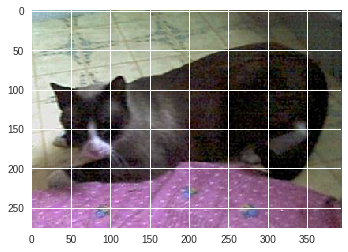

In [17]:
img = plt.imread(f'{PATH}valid/cats/{files[1]}')
plt.imshow(img);

Here is how the raw data looks like

In [0]:
img.shape

(276, 394, 3)

In [0]:
img[:4,:4]

array([[[112, 134, 147],
        [112, 134, 147],
        [113, 135, 148],
        [113, 135, 148]],

       [[112, 134, 147],
        [112, 134, 147],
        [113, 135, 148],
        [113, 135, 148]],

       [[112, 134, 147],
        [112, 134, 147],
        [113, 135, 148],
        [113, 135, 148]],

       [[112, 134, 147],
        [112, 134, 147],
        [113, 135, 148],
        [113, 135, 148]]], dtype=uint8)

##Our first model quickstart

We're going to use a <b>pre-trained</b> model, that is, a model created by some one else to solve a different problem. Instead of building a model from scratch to solve a similar problem, we'll use a model trained on ImageNet (1.2 million images and 1000 classes) as a starting point. The model is a Convolutional Neural Network (CNN), a type of Neural Network that builds state-of-the-art models for computer vision. We'll be learning all about CNNs during this course.

We will be using the <b>resnet34</b> model. resnet34 is a version of the model that won the 2015 ImageNet competition. Here is more info on [resnet models](https://github.com/KaimingHe/deep-residual-networks). We'll be studying them in depth later, but for now we'll focus on using them effectively.

Here's how to train and evalulate a *dogs vs cats* model in 3 lines of code, and under 20 seconds:

In [0]:
# Uncomment the below if you need to reset your precomputed activations
# shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

In [19]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

100%|██████████| 32/32 [00:14<00:00,  2.18it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.055122   0.025459   0.989     
    1      0.039001   0.023762   0.991     



[array([0.02376]), 0.991]

How good is this model? Well, as we mentioned, prior to this competition, the state of the art was 80% accuracy. But the competition resulted in a huge jump to 98.9% accuracy, with the author of a popular deep learning library winning the competition. Extraordinarily, less than 4 years later, we can now beat that result in seconds! Even last year in this same course, our initial model had 98.3% accuracy, which is nearly double the error we're getting just a year later, and that took around 10 minutes to compute.

##Analyzing results: looking at pictures

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (i.e. those with highest probability that are correct)
4. The most incorrect labels of each class (i.e. those with highest probability that are incorrect)
5. The most uncertain labels (i.e. those with probability closest to 0.5).

In [20]:
# This is the label for a val data
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [21]:
# from here we know that 'cats' is label 0 and 'dogs' is label 1.
data.classes

['cats', 'dogs']

In [22]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [23]:
log_preds[:10]

array([[ -0.00016,  -8.73179],
       [ -0.00075,  -7.20096],
       [ -0.00226,  -6.0915 ],
       [ -0.00005,  -9.94515],
       [ -0.00004, -10.25113],
       [ -0.     , -12.44198],
       [ -0.00062,  -7.38759],
       [ -0.00013,  -8.96274],
       [ -0.00043,  -7.76014],
       [ -0.00017,  -8.67912]], dtype=float32)

In [0]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [0]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [0]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [0]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


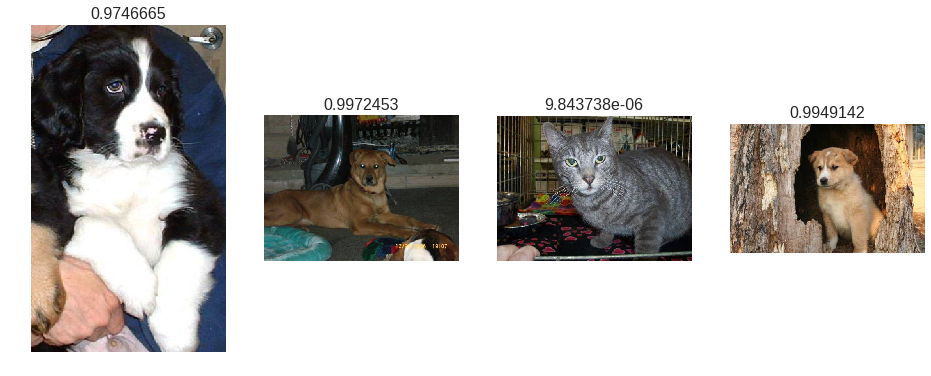

In [31]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


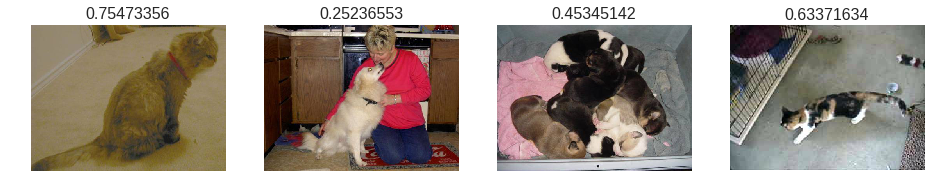

In [0]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [0]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct cats


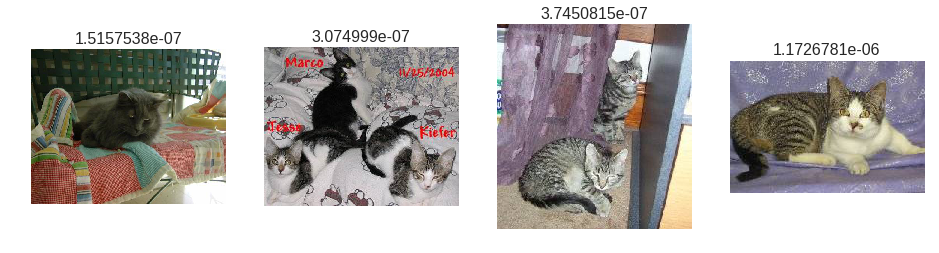

In [33]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

Most correct dogs


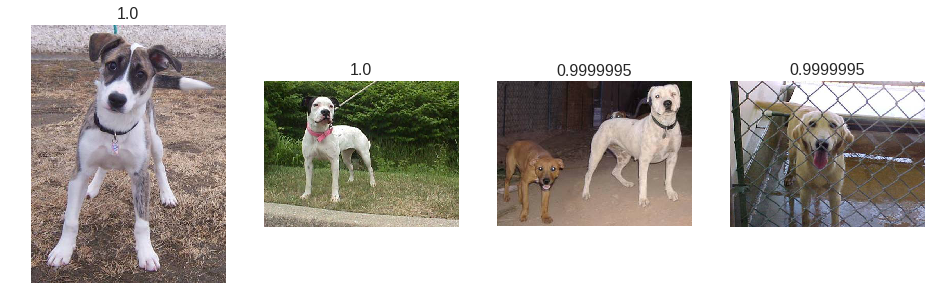

In [0]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

Most incorrect cats


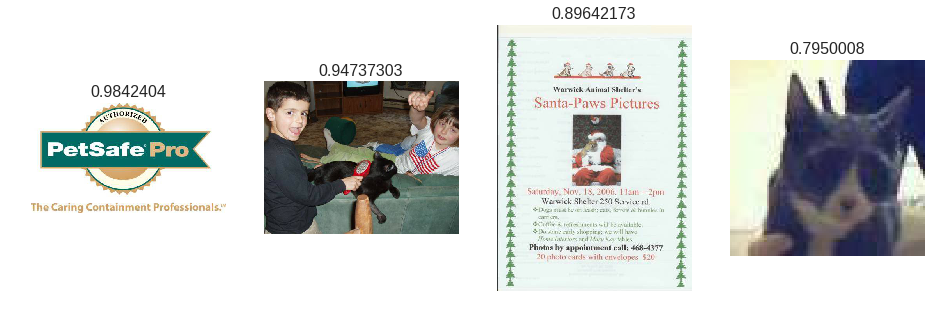

In [0]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


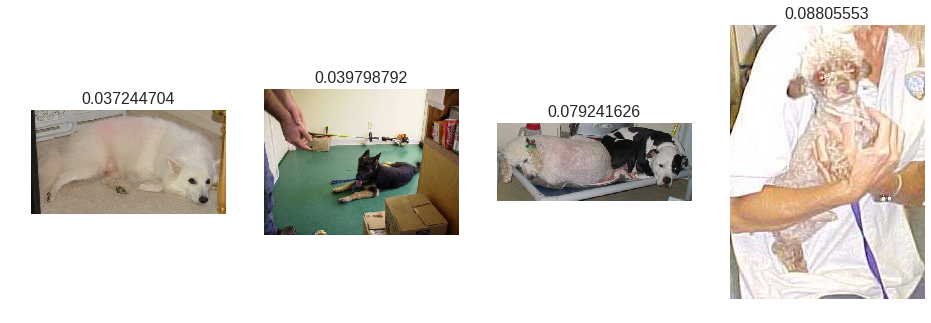

In [0]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Most uncertain predictions


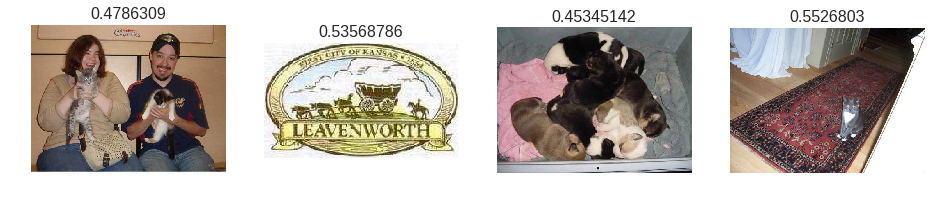

In [0]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

##Choosing a learning rate

The *learning rate* determines how quickly or how slowly you want to update the *weights* (or *parameters*). Learning rate is one of the most difficult parameters to set, because it significantly affects model performance.

The method `learn.lr_find()` helps you find an optimal learning rate. It uses the technique developed in the 2015 paper [Cyclical Learning Rates for Training Neural Networks](http://arxiv.org/abs/1506.01186), where we simply keep increasing the learning rate from a very small value, until the loss stops decreasing. We can plot the learning rate across batches to see what this looks like.

We first create a new learner, since we want to know how to set the learning rate for a new (untrained) model.

In [0]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [35]:
lrf=learn.lr_find()

 81%|████████  | 291/360 [00:07<00:01, 39.11it/s, loss=0.432]


Our learn object contains an attribute sched that contains our learning rate scheduler, and has some convenient plotting functionality including this one:

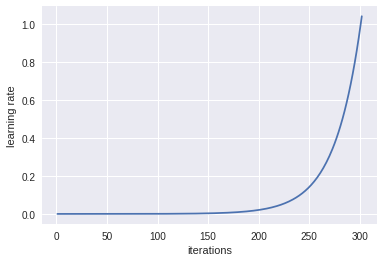

In [36]:
learn.sched.plot_lr()

Note that in the previous plot iteration is one iteration (or minibatch) of SGD. In one epoch there are (num_train_samples/batch_size) iterations of SGD.

We can see the plot of loss versus learning rate to see where our loss stops decreasing:

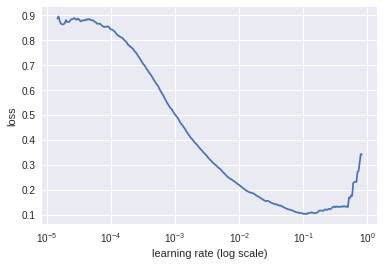

In [37]:
learn.sched.plot()

The loss is still clearly improving at lr=1e-2 (0.01), so that's what we use. Note that the optimal learning rate can change as we train the model, so you may want to re-run this function from time to time.

##Improving our model

###Data augmentation

If you try training for more epochs, you'll notice that we start to overfit, which means that our model is learning to recognize the specific images in the training set, rather than generalizing such that we also get good results on the validation set. One way to fix this is to effectively create more data, through data augmentation. This refers to randomly changing the images in ways that shouldn't impact their interpretation, such as horizontal flipping, zooming, and rotating.

We can do this by passing aug_tfms (augmentation transforms) to tfms_from_model, with a list of functions to apply that randomly change the image however we wish. For photos that are largely taken from the side (e.g. most photos of dogs and cats, as opposed to photos taken from the top down, such as satellite imagery) we can use the pre-defined list of functions transforms_side_on. We can also specify random zooming of images up to specified scale by adding the max_zoom parameter.


In [0]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [0]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [0]:
ims = np.stack([get_augs() for i in range(6)])

In [0]:
plots(ims, rows=2)

Let's create a new data object that includes this augmentation in the transforms.

In [0]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [0]:
learn.fit(1e-2, 1)

In [0]:
learn.precompute=False

By default when we create a learner, it sets all but the last layer to *frozen*. That means that it's still only updating the weights in the last layer when we call `fit`.

In [0]:
learn.fit(1e-2, 3, cycle_len=1)

What is that `cycle_len` parameter? What we've done here is used a technique called *stochastic gradient descent with restarts (SGDR)*, a variant of *learning rate annealing*, which gradually decreases the learning rate as training progresses. This is helpful because as we get closer to the optimal weights, we want to take smaller steps.



However, we may find ourselves in a part of the weight space that isn't very resilient - that is, small changes to the weights may result in big changes to the loss. We want to encourage our model to find parts of the weight space that are both accurate and stable. Therefore, from time to time we increase the learning rate (this is the 'restarts' in 'SGDR'), which will force the model to jump to a different part of the weight space if the current area is "spikey". Here's a picture of how that might look if we reset the learning rates 3 times (in this paper they call it a "cyclic LR schedule"):

<img src="images/sgdr.png" width="80%">
(From the paper [Snapshot Ensembles](https://arxiv.org/abs/1704.00109)).

The number of epochs between resetting the learning rate is set by `cycle_len`, and the number of times this happens is refered to as the *number of cycles*, and is what we're actually passing as the 2nd parameter to `fit()`. So here's what our actual learning rates looked like:

In [0]:
learn.sched.plot_lr()